In [1]:
#Generates input spike trains (to be stored in ../input_spike_trains/FILENAME.dat)
filename = 'spike_trains_DG_L23_NR'  #to save spikes to
inp_map_file = 'input_map1_2.csv' #to load input mapping data from (needs to be computed beforehand!)

from_file = True
project_path = 'C:/Users/Christoph Pokorny/Dropbox/SWDB-2016/project/'

#spontaneous (SP)
#mat_file = [project_path + 'spontaneous/L4_cux2_spiketime.mat', #to load spike data from
#            project_path + 'spontaneous/L4_Rorb2_spiketime.mat', #to load spike data from
#            project_path + 'spontaneous/L4_Scnn1a_spiketime.mat'] #to load spike data from
#num_ch_sel = [250, 250, 250]

#local sparse noise (LSN)
#mat_file = [project_path + 'localsparsenoise/L4_Cux2_VISp_spiketime_added_and_picked.mat', #to load spike data from
#            project_path + 'localsparsenoise/L4_Rorb_VISp_spiketime_added_and_picked.mat', #to load spike data from
#            project_path + 'localsparsenoise/L4_Scnn1a_VISp_spiketime_added_and_picked.mat'] #to load spike data from
#num_ch_sel = [250, 250, 250]

#drifting gratings (DG)
#mat_file = [project_path + 'drifting_gratings/L4_Cux2_VISp_spiketime.mat', #to load spike data from
#            project_path + 'drifting_gratings/L4_Rorb_VISp_spiketime.mat', #to load spike data from
#            project_path + 'drifting_gratings/L4_Scnn1a_VISp_spiketime.mat'] #to load spike data from
#num_ch_sel = [250, 250, 250]
#mat_file = [project_path + 'drifting_gratings_nonrunning/L4_Cux2_VISpnonrunning_spiketime.mat', #to load spike data from
#            project_path + 'drifting_gratings_nonrunning/L4_Rorb_VISpnonrunning_spiketime.mat', #to load spike data from
#            project_path + 'drifting_gratings_nonrunning/L4_Scnn1a_VISpnonrunning_spiketime.mat'] #to load spike data from
#num_ch_sel = [250, 250, 250]

#L23 data
mat_file = project_path + 'drifting_gratings_nonrunning/L23_VISpnonrunning_spiketime.mat' #to load spike data from
num_ch_sel = 400

#from_file = False
#signal_length = 1.0 #(s)
#dt = 0.00001 #(s)
#firing_rate = 5.0 #(Hz)

num_trials = 1

In [2]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
#%matplotlib notebook
%matplotlib inline

In [3]:
inp_map = pd.DataFrame.from_csv('../build/' + inp_map_file, sep=' ')
num_inputs = np.max(inp_map.src_gid)+1
print('%d spike sources to be created...'%(num_inputs))

750 spike sources to be created...


In [4]:
if from_file:
    if type(mat_file)!=list:
        mat_file = [mat_file]
    if type(num_ch_sel)!=list:
        num_ch_sel = [num_ch_sel]
    assert len(mat_file)==len(num_ch_sel), 'ERROR: List of numbers of channels to select from each file needed!'
    num_cells_in_files = []
    for n in range(len(mat_file)):
        mat_tmp = sio.loadmat(mat_file[n])
        key_tmp = np.array(mat_tmp.keys())[np.array([mat_tmp.keys()[k].find('spiketm')>=0 for k in range(len(mat_tmp.keys()))])][0] #find key which starts with 'spiketm'
        spike_data_tmp = mat_tmp[key_tmp]
        num_cells_in_files.append(spike_data_tmp.shape[1])
    print('Available numbers of cells in files:')
    print(num_cells_in_files)
    assert np.all(np.array(num_ch_sel)<=np.array(num_cells_in_files)), 'ERROR: Not enough cells provided for channel selection!'
    #assert np.sum(num_ch_sel)==num_inputs, 'ERROR: Wrong number of cells selected (must sum up to %d)!'%(num_inputs)

Available numbers of cells in files:
[1099L]


In [5]:
assert num_trials==1, 'Only 1 trial supported!'
if from_file:
    if type(mat_file)!=list:
        mat_file = [mat_file]
    #load from .mat file(s)
    spike_times = []
    for n in range(len(mat_file)):
        mat_tmp = sio.loadmat(mat_file[n])
        key_tmp = np.array(mat_tmp.keys())[np.array([mat_tmp.keys()[k].find('spiketm')>=0 for k in range(len(mat_tmp.keys()))])][0] #find key which starts with 'spiketm'
        spike_data_tmp = mat_tmp[key_tmp]
        num_channels_tmp = spike_data_tmp.shape[1]
        print('%d cells loaded from %s (%d required)...'%(num_channels_tmp, mat_file[n][mat_file[n].rfind('/')+1:], num_ch_sel[n]))
        assert num_channels_tmp>=num_ch_sel[n], 'ERROR: Not enough channels provided!'
        #for k in range(num_ch_sel[n]): #only read first num_ch_sel[n] channels
        for k in np.random.choice(num_channels_tmp, num_ch_sel[n], replace=False): #random subsampling of num_ch_sel[n] channels
            spike_times.append(list(spike_data_tmp[0][k][:, 0])) #assume times in (s)
    signal_length = max([max(spike_times[k]) if len(spike_times[k])>0 else 0 for k in range(len(spike_times))])
    print('Signal length: %.2fs'%(signal_length))
else:
    #generate Poisson spike trains
    time_axis = np.arange(0, signal_length, dt)
    spike_times = []
    for k in range(num_inputs):
        spike_times_tmp = []
        for n, t in enumerate(time_axis):
            if firing_rate*dt>=np.random.rand():
                spike_times_tmp.append(t)
        spike_times.append(spike_times_tmp)

1099 cells loaded from L23_VISpnonrunning_spiketime.mat (400 required)...
Signal length: 144.00s


In [6]:
#write to file
f = open('../input_spike_trains/' + filename + '.dat', 'w')
for k in range(len(spike_times)):
    for n in range(len(spike_times[k])):
        f.write(' %.3f'%(1e3*spike_times[k][n])) #convert to (ms)
    f.write('\n')
f.close()

In [7]:
'''
#load from file - FOR TESTING ONLY
f = open('../input_spike_trains/' + filename + '.dat', 'r')
spikes = f.readlines()
f.close()
spike_times = []
for n in range(len(spikes)):
    spike_train = spikes[n][1:-2].split(' ')
    spike_train = [1e-3*float(spike_train[k]) for k in range(len(spike_train))] #convert to (s)
    spike_times.append(spike_train)
signal_length = max(max(spike_times))
num_inputs = len(spikes)
'''

"\n#load from file - FOR TESTING ONLY\nf = open('../input_spike_trains/' + filename + '.dat', 'r')\nspikes = f.readlines()\nf.close()\nspike_times = []\nfor n in range(len(spikes)):\n    spike_train = spikes[n][1:-2].split(' ')\n    spike_train = [1e-3*float(spike_train[k]) for k in range(len(spike_train))] #convert to (s)\n    spike_times.append(spike_train)\nsignal_length = max(max(spike_times))\nnum_inputs = len(spikes)\n"

In [8]:
#compute ISIs
ISIs = [list(np.diff(spike_times[k])) for k in range(len(spike_times))]
ISI_list = []
for n in range(len(ISIs)):
    ISI_list += ISIs[n]

In [9]:
#compute mean rates
firing_rates = [1.0*len(spike_times[k])/signal_length for k in range(len(spike_times))] #compute single-cell firing rates
num_spikes = np.sum([len(spike_times[k]) for k in range(len(spike_times))])  #total number of spikes
mean_rate = 1.0*num_spikes/(signal_length*len(spike_times))
pop_rate = 1.0*num_spikes/(signal_length)
print('Mean firing rate: %.2fHz'%(mean_rate))
print('Population firing rate: %.2fHz'%(pop_rate))

Mean firing rate: 0.20Hz
Population firing rate: 78.09Hz


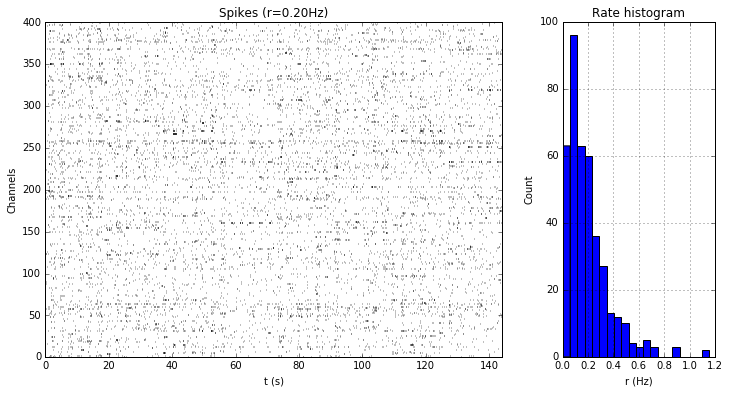

In [10]:
#plot spikes
ch_max = len(spike_times) #max. number of channels to plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [3, 1]})
for n in range(min(len(spike_times), ch_max)):
    ax[0].plot(spike_times[n], (n + 1)*np.ones_like(spike_times[n]), '|k', markersize=1)
    #ax[0].plot([spike_times[n], spike_times[n]], [(0.5+n)*np.ones_like(spike_times[n]), (1.5+n)*np.ones_like(spike_times[n])], 'k')
ax[0].set_xlim((0, signal_length))
#ax[0].set_xlim((0, 100))
ax[0].set_ylim((0.5, min(len(spike_times), ch_max)+0.5))
ax[0].set_xlabel('t (s)')
ax[0].set_ylabel('Channels')
ax[0].set_title('Spikes (r=%.2fHz)'%(mean_rate))
ax[1].hist(np.array(firing_rates), 20)
ax[1].set_xlabel('r (Hz)')
ax[1].set_ylabel('Count')
ax[1].set_title('Rate histogram')
ax[1].grid(True)
#ax[1].hist(np.array(ISI_list), 20)
#ax[1].set_xlabel('ISI (s)')
#ax[1].set_ylabel('Count')
#ax[1].set_title('ISI histogram')
#ax[1].grid(True)
fig.savefig('../input_spike_trains/' + filename + '.png', dpi=600)